# Predict 3 phase set points from Tanks 2/3/4/5 and Mod 6 BPM/TOR data

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import math
#import sklearn.mixture
# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

%matplotlib widget
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams["savefig.format"] = 'pdf'

In [4]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.callbacks import LearningRateScheduler

print(tf.__version__)

2.5.0


## DNN regression models

The base model contains the following layers:

* The normalization layer.
* Four hidden, nonlinear, `Dense` layers using the `relu` nonlinearity.
* A linear single-output layer.

We also test a model without input normalization layer.

In [5]:
def build_and_compile_model(norm, init_lr):
  model = keras.Sequential([
      norm,
      layers.Dense(100, activation='relu'),
      layers.Dense(100, activation='relu'),
      layers.Dense(100, activation='relu'),
      layers.Dense(100, activation='relu'),
      #layers.Dense(100, activation='relu'),
      #layers.Dense(100, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_squared_error', steps_per_execution=30,
                optimizer=tf.keras.optimizers.Adam(init_lr))
  return model

def build_and_compile_model_nonorm(inputs,init_lr):
  model = keras.Sequential([
      keras.Input(shape=(inputs,)),
      layers.Dense(100, activation='relu'),
      layers.Dense(100, activation='relu'),
      layers.Dense(100, activation='relu'),
      layers.Dense(100, activation='relu'),
      #layers.Dense(100, activation='relu'),
      #layers.Dense(100, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_squared_error', steps_per_execution=30,
                optimizer=tf.keras.optimizers.Adam(init_lr))
  return model

In [6]:
# Define learning schedules 

initial_lr = 0.001

def lr_time_based_decay(epoch, lr):
    epochs = 400
    decay = initial_lr / epochs
    return lr * 1 / (1 + decay * epoch)


def lr_step_decay(epoch, lr):
    drop_rate = 0.5
    epochs_drop = 200.0
    return initial_lr * math.pow(drop_rate, math.floor(epoch/epochs_drop))

def lr_exp_decay(epoch, lr):
    k = 0.1
    return initial_lr * math.exp(-k*epoch)



In [7]:
def train_model(model,features,labels,eps,lrs=None):
    if lrs is None:
        history = model.fit(
            features, 
            labels,
            validation_split=0.2,
            batch_size=30,
            verbose=0,
            epochs=int(eps)
        )
    else:
        history = model.fit(
            features, 
            labels, 
            validation_split=0.2,
            batch_size=30,
            verbose=0,
            epochs=int(eps), 
            callbacks=[LearningRateScheduler(lrs, verbose=0)],
        )
    return history

In [8]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([1, 5])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

def plot_multi_loss(histories):
    fig, ax = plt.subplots(len(histories),1,figsize=(9,9))
    for i in range(len(histories)):
        ax[i].plot(histories[i].history['loss'], label='loss')
        ax[i].plot(histories[i].history['val_loss'], label='val_loss')
        ax[i].set_ylim([0, 5])
        ax[i].set(xlabel='Epoch', ylabel='Loss')
        ax[i].legend()
        ax[i].grid(True)
        
    fig.tight_layout()


### Get the data

In [17]:
def fetch_data(file):
    dataset = pd.read_csv(file)
    dataset.columns = dataset.columns.str.replace("[()]", "_",regex=True)

    cols = list(dataset.filter(regex='L7PADJ|BQ2|HPQ2|VPQ2'))
    # for set points, keep _S_ and drop _R_ if available
    cols = [col for col in cols if col.find('L7PADJ_R')==-1]
    
    subset = dataset.loc[:,cols]
    subset.columns = subset.columns.str.replace("_R_|_S_", "",regex=True)
    subset.drop(list(subset.filter(regex=r'\.1|Time|step|iter')),axis=1, inplace=True)

    #subset = subset.loc[(subset['L:BPH2OT']!=0) & (subset['L:BPV2OT']!=0) & (subset['L:BPM2OF']!=0)]
    #subset = subset.loc[(subset['L:BPH3OT']!=0) & (subset['L:BPV3OT']!=0) & (subset['L:BPM3OF']!=0)]
    subset.dropna()
    
    return subset

In [18]:
def fetch_reference(dataset):
    #rfb = np.median(dataset['L:RFBPAH'])
    #rfq = np.median(dataset['L:RFQPAH'])
    #v5q = np.median(dataset['L:V5QSET'])
    #print(rfb,rfq,v5q)
    l7padj= 90.0

    #reference = dataset.loc[(np.abs(dataset['L:RFQPAH']-rfq)<0.5) & (np.abs(dataset['L:RFBPAH']-rfb)<0.5) & (np.abs(dataset['L:V5QSET']-v5q)<0.1)].mean()
    reference = dataset.loc[(np.abs(dataset['L:L7PADJ']-l7padj))].mean()

    return reference

In [19]:
def fetch_features_labels(dataset):
    features = dataset.copy()
    labelstr = list(dataset.filter(regex='L7PADJ'))
    labels = features.loc[:,labelstr]
    features.drop(columns=labelstr, inplace=True)
    
    return features,labels

In [20]:
def plot_2dhist(predictions,labels):

    fig, ax = plt.subplots(1,1, figsize=(5,5))
    fig.tight_layout()
    devs = ['Module 7']
    
    for i in range(labels.shape[1]):
        #key = labels.columns[i]
        key = devs[i]
        h = ax[i].hist2d(labels.iloc[:,i], predictions[:,i], bins=40, cmin=1, cmap='seismic')
        #ax[i].set(xlabel='True Values %s'%key, ylabel='Predictions %s'%key)
        ax[i].set(title='%s'%key)
        ax[i].tick_params(axis='both',labelsize=14)
        lims = [min(np.min(predictions[:,i]),np.min(labels.iloc[:,i])),
                max(np.max(predictions[:,i]),np.max(labels.iloc[:,i]))]
        ax[i].set_xlim(lims)
        ax[i].set_ylim(lims)
        ax[i].plot(lims, lims, color='k')
        fig.colorbar(h[3], ax=ax[i])
    fig.supylabel('Predicted $\Delta$ phase (deg)', fontsize=18)
    fig.suptitle('True $\Delta$ phase (deg)', y=0.05, fontsize=18)   
    plt.subplots_adjust(wspace=0.1, hspace=0)
    plt.subplots_adjust(bottom=0.15)
    plt.subplots_adjust(top=0.92)
    plt.subplots_adjust(left=0.09)
    plt.subplots_adjust(right=0.96)  

In [21]:
def plot_2dscatter(predictions,labels):

    fig, ax = plt.subplots(1,1, figsize=(4,4))

    for i in range(labels.shape[1]):
        key = labels.columns[i]
        ax[i].scatter(test_labels.iloc[:,i], test_predictions[:,i], color='r')
        ax[i].set(xlabel='True Values %s'%key, ylabel='Predictions %s'%key)
        lims = [min(np.min(predictions[:,i]),np.min(labels.iloc[:,i])),
                max(np.max(predictions[:,i]),np.max(labels.iloc[:,i]))]
        #ax[i].set_xlim(lims)
        #ax[i].set_ylim(lims)
        print(lims)
        ax[i].plot(lims, lims, color='b')    
    fig.tight_layout()

In [12]:
def plot_1derror(predictions,labels):
    
    props = dict(boxstyle='round', facecolor='white', alpha=0.4)
    devs = ['RFQ','MEBT Buncher','DTL Tank 5']
    fig, ax = plt.subplots(1,3, figsize=(9,3.5),sharey=False)
    fig.tight_layout()
    for i in range(labels.shape[1]):
        #key = labels.columns[i]
        key = devs[i]
        error =(predictions[:,i] - labels.iloc[:,i])
        nbins=85
        ax[i].hist(error, bins=nbins, color='r', edgecolor='k', alpha=0.65, label='Data')
        #ax[i].set(title='%s'%key ,xlabel='Prediction Error (deg)', ylabel='Count')
        ax[i].set(title='%s'%key)
        #ax[i].xaxis.label.set_size(13)
        #ax[i].yaxis.label.set_size(13)
        
        ers = np.array(error)[:,None]
        gmm = sklearn.mixture.GaussianMixture()  
        r = gmm.fit(ers)
        mean = r.means_[0, 0]
        sigma = np.sqrt(r.covariances_[0,0])
        textstr = '\n'.join((
                    r'$\mu=%.2f$' % (mean,),
                    r'$\sigma=%.2f$' % (sigma,)))
        print(textstr)                                                                                                                  
        xlin = np.linspace(np.min(error),np.max(error),1000).reshape(-1,1)                                                                                                                             
        pdf = np.exp(gmm.score_samples(xlin))
        binsize = (np.max(error) - np.min(error))/nbins
        ax[i].plot(xlin,pdf*(len(error)*binsize),color='k', label='Gauss fit')
        ax[i].text(0.05, 0.65, textstr, transform=ax[i].transAxes, color='k', fontsize=14,                                                                                
                           verticalalignment='top', bbox=props)
        ax[i].legend(fontsize=14, loc='upper left')
        ax[i].tick_params(axis='both',labelsize=14)
     
    fig.supylabel('Entries/Bin', fontsize=18)
    fig.suptitle('Prediction error (degrees)', y=0.05, fontsize=18)
    plt.subplots_adjust(wspace=0.19, hspace=0)
    plt.subplots_adjust(bottom=0.17)
    plt.subplots_adjust(top=0.92)
    plt.subplots_adjust(left=0.09)
    plt.subplots_adjust(right=0.96)  


In [22]:
#file = r'/Users/rshara01/Desktop/LINAC_STUDY/BEAM STUDY 24MAY2022/devicescan.csv'
#file = r'/Users/rshara01/Desktop/LINAC_STUDY/BEAM STUDY 15JUNE2022/devicescan_3ph_jun15.csv'
file=r'devicescan_l7padj_loopON_52_10rep.csv'
dataset = fetch_data(file)

reference = fetch_reference(dataset)

dataset = dataset - reference

KeyError: "None of [Float64Index([      44.89501953,       44.89501953,       44.89501953,\n                    44.89501953,       44.89501953,       44.89501953,\n                    44.89501953,       44.89501953,       44.89501953,\n                    44.89501953,\n              ...\n              9.906921389999994, 9.906921389999994, 9.906921389999994,\n              9.906921389999994, 9.906921389999994, 9.906921389999994,\n              9.906921389999994, 9.906921389999994, 9.906921389999994,\n              9.906921389999994],\n             dtype='float64', length=560)] are in the [index]"

### Split the data into train and test

We split the dataset into a training set and a test set.
The test set is used in the final evaluation of the model.

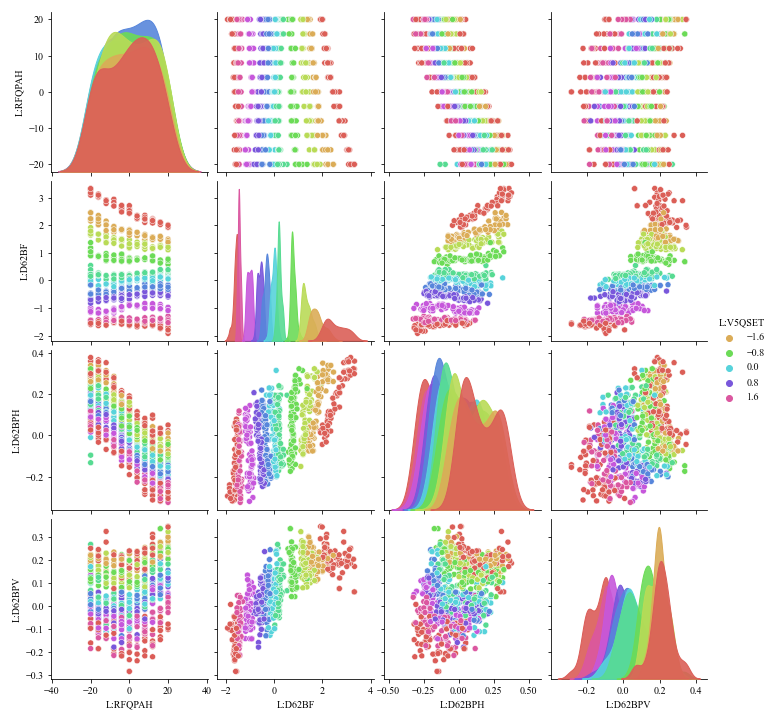

In [14]:
train_dataset = dataset.sample(frac=0.8, random_state=10)
test_dataset = dataset.drop(train_dataset.index)

#inspect the data
sns.pairplot(train_dataset, vars=['','B:BQ2F','B:HPQ2','B:VPQ2'], hue='L:L7PADJ', palette='hls',diag_kind='kde',diag_kws={'alpha':0.9})#, height=2.0)
#sns.pairplot(train_dataset.loc[np.abs(train_dataset['L:RFBPAH'])<1.], vars=['L:RFQPAH','L:D62BF','L:D62BPH','L:D62BPV'], hue='L:V5QSET', palette='hls',diag_kind='kde',diag_kws={'alpha':0.9})#, height=2.0)
#sns.pairplot(train_dataset.loc[np.abs(train_dataset['L:RFBPAH'])<1.], vars=['L:DRQF','L:BGASV','L:BEXTI','L:BEXTV'], hue='L:RFQPAH', palette='hls',diag_kind='kde',diag_kws={'alpha':0.9})#, height=2.0)

In [224]:
plt.savefig('d64_data_overview.pdf')

### Split features from labels

Separate the target values, the "labels", from the features. These labels are the values that we train the model to predict: RFQ, Buncher and Tank 5 phase.

In [15]:
train_features, train_labels = fetch_features_labels(train_dataset)
test_features, test_labels = fetch_features_labels(test_dataset)

## Normalization

In the table of statistics it's easy to see how different the ranges of each feature are. To improve training we normalize all inputs to the same range.

In [16]:
train_features.describe().transpose()[['mean','std']].transpose()

,L:BPM2OF,L:BPM3IF,L:BPM3OF,L:BPM4IF,L:BPM5IF,L:BPM5OF,L:D61BF,L:D62BF,L:D63BF,L:D64BF,...,L:BPV2OT,L:BPV3IN,L:BPV3OT,L:BPV4IN,L:BPV5IN,L:BPV5OT,L:D61BPV,L:D62BPV,L:D63BPV,L:D64BPV
mean,-0.044540,-0.024875,0.050298,-0.007270,-0.669524,0.415627,0.303966,0.174398,-0.011737,-0.083336,...,-0.054395,-0.014381,-0.045833,-0.036191,0.065877,0.067661,-0.002781,0.074907,0.010522,0.044304
std,3.400771,2.465986,3.397564,2.500514,1.499997,4.799115,2.190002,1.302903,0.551819,1.535299,...,0.054293,0.091580,0.081179,0.112586,0.062544,0.285302,0.050286,0.133735,0.053140,0.196860


### The Normalization layer
This calculates the mean and variance, and stores them in the layer. 
When the layer is called it returns the input data, with each feature independently normalized.

In [18]:
normalizer = preprocessing.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))

2022-11-07 10:40:54.727944: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-07 10:40:54.741337: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


## Train the model

In [19]:
%%time
#dnn_model2 = build_and_compile_model_nonorm(train_features.shape[1],initial_lr)

dnn_model11 = build_and_compile_model(normalizer, initial_lr)
history_flat = train_model(dnn_model11,train_features,train_labels,100)
dnn_model11.summary()

2022-11-07 10:41:06.557192: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-07 10:41:09.482465: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 30)                61        
_________________________________________________________________
dense (Dense)                (None, 100)               3100      
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 303       
Total params: 33,764
Trainable params: 33,703
Non-trainable params: 61
___________________________________________________

In [20]:
%%time

dnn_model12 = build_and_compile_model(normalizer, initial_lr)
history_time_decay = train_model(dnn_model12,train_features,train_labels,100,lr_time_based_decay)

2022-11-07 10:43:50.146191: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-07 10:43:51.748637: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


CPU times: user 2min 34s, sys: 1min 38s, total: 4min 12s
Wall time: 2min 47s


In [21]:
%%time

dnn_model13 = build_and_compile_model(normalizer, initial_lr)
history_step = train_model(dnn_model13,train_features,train_labels,100,lr_step_decay)

2022-11-07 10:46:37.838151: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-07 10:46:39.658222: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


CPU times: user 2min 38s, sys: 1min 36s, total: 4min 14s
Wall time: 2min 48s


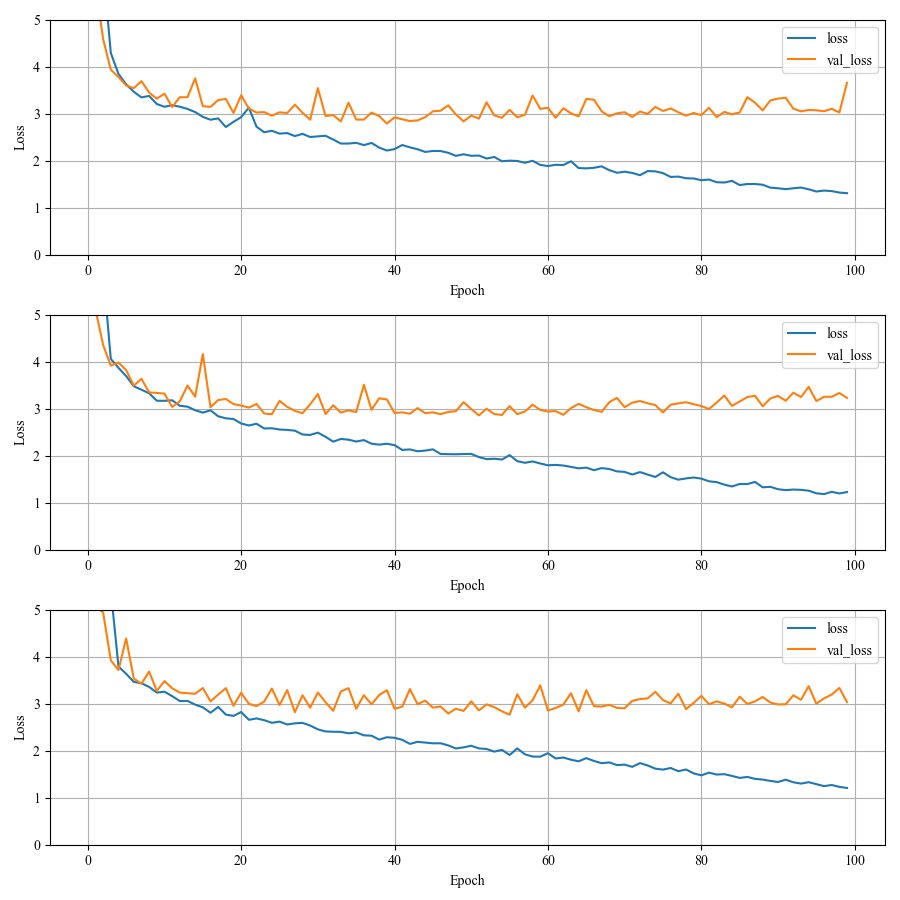

In [22]:
plot_multi_loss([history_flat,history_time_decay,history_step])

If you're happy with the model save it for later use:

In [50]:
dnn_model13.save('dnn_model13_LE+mod6_delta_100epochs_27052022data_noTOR')

2022-08-02 10:01:21.702386: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: dnn_model13_LE+mod6_delta_100epochs_27052022data_noTOR/assets


## Performance
Test the model on the test set:

In [ ]:
loaded_model = tf.keras.models.load_model('dnn_model13_LE+mod6_delta_100epochs_27052022data_noTOR')

In [23]:
test_results = {}

test_results['dnn_model'] = dnn_model13.evaluate(test_features, test_labels, verbose=1)

test_predictions = dnn_model13.predict(test_features)

75/75 [==============================] - 0s 5ms/step - loss: 3.1453


2022-11-07 10:50:22.055379: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


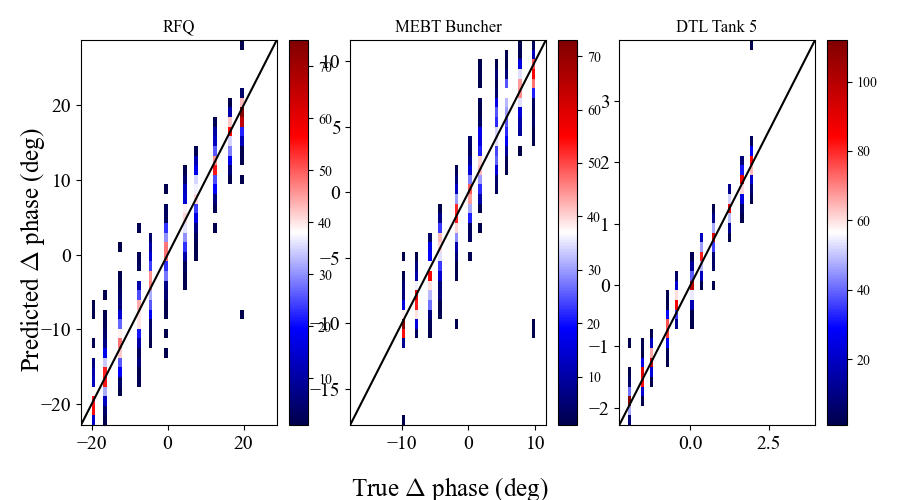

In [24]:
%matplotlib widget
plot_2dhist(test_predictions,test_labels)

In [221]:
plt.savefig('predictionTrue_good.pdf')

$\mu=-0.01$
$\sigma=2.60$
$\mu=-0.17$
$\sigma=1.62$
$\mu=0.05$
$\sigma=0.17$


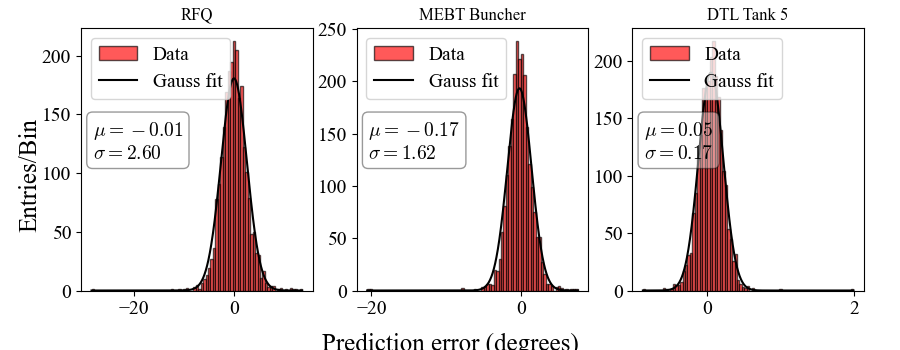

In [25]:
plot_1derror(test_predictions,test_labels)


In [173]:
plt.savefig("predictionErr_good.pdf")

In [26]:
val1 = r'/Users/rshara01/Desktop/LINAC_STUDY/BEAM STUDY 15JUNE2022/devicescan_3ph_jun15.csv'
val2 = r'/Users/rshara01/Desktop/LINAC_STUDY/Daily_snapshots/2022_05_27-09_00_04_devicescan.csv.zip'
val3 = r'/Users/rshara01/Desktop/LINAC_STUDY/Daily_snapshots/2022_05_23-17_00_03_devicescan.csv.zip'
#val1 = r'/Users/rshara01/Desktop/LINAC_STUDY/Daily_snapshots/2022_06_15-20_00_05_devicescan.csv.zip'
#val1 = r'/Users/rshara01/Desktop/LINAC_STUDY/Daily_snapshots/2022_07_08-19_00_03_devicescan.csv.zip'


In [27]:
vdf = fetch_data(val1)
vdf = vdf - reference

val_features,val_labels = fetch_features_labels(vdf)
val_predictions = dnn_model13.predict(val_features)

print(val_labels.columns)

Index(['L:RFQPAH', 'L:RFBPAH', 'L:V5QSET'], dtype='object')


In [28]:
train_features.describe().transpose()[['mean','std']].transpose()

,L:BPM2OF,L:BPM3IF,L:BPM3OF,L:BPM4IF,L:BPM5IF,L:BPM5OF,L:D61BF,L:D62BF,L:D63BF,L:D64BF,...,L:BPV2OT,L:BPV3IN,L:BPV3OT,L:BPV4IN,L:BPV5IN,L:BPV5OT,L:D61BPV,L:D62BPV,L:D63BPV,L:D64BPV
mean,-0.044540,-0.024875,0.050298,-0.007270,-0.669524,0.415627,0.303966,0.174398,-0.011737,-0.083336,...,-0.054395,-0.014381,-0.045833,-0.036191,0.065877,0.067661,-0.002781,0.074907,0.010522,0.044304
std,3.400771,2.465986,3.397564,2.500514,1.499997,4.799115,2.190002,1.302903,0.551819,1.535299,...,0.054293,0.091580,0.081179,0.112586,0.062544,0.285302,0.050286,0.133735,0.053140,0.196860


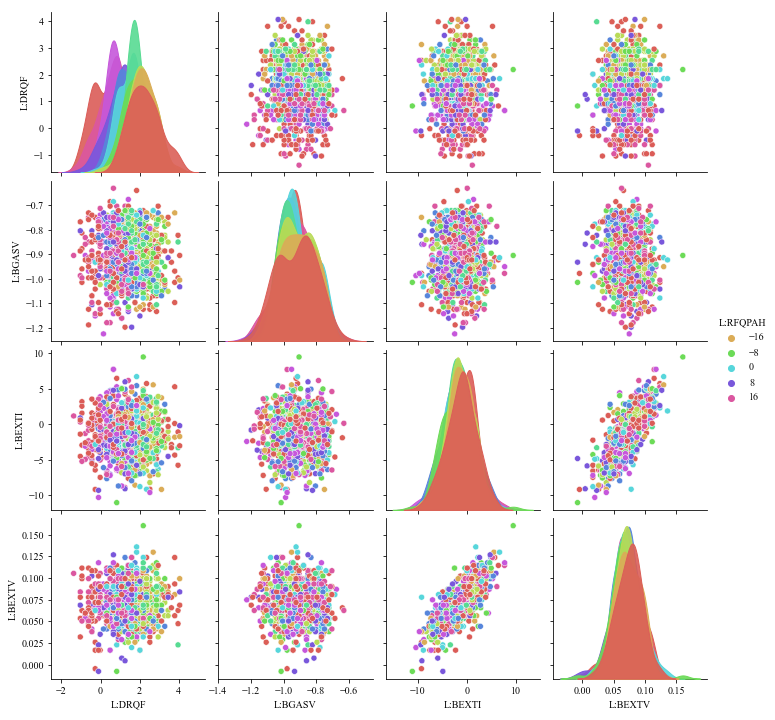

In [34]:
val_features.describe().transpose()[['mean','std']].transpose()
sns.pairplot(vdf.loc[np.abs(vdf['L:RFBPAH'])<1.], vars=['L:DRQF','L:BGASV','L:BEXTI','L:BEXTV'], hue='L:RFQPAH', palette='hls',diag_kind='kde',diag_kws={'alpha':0.9})#, height=2.0)

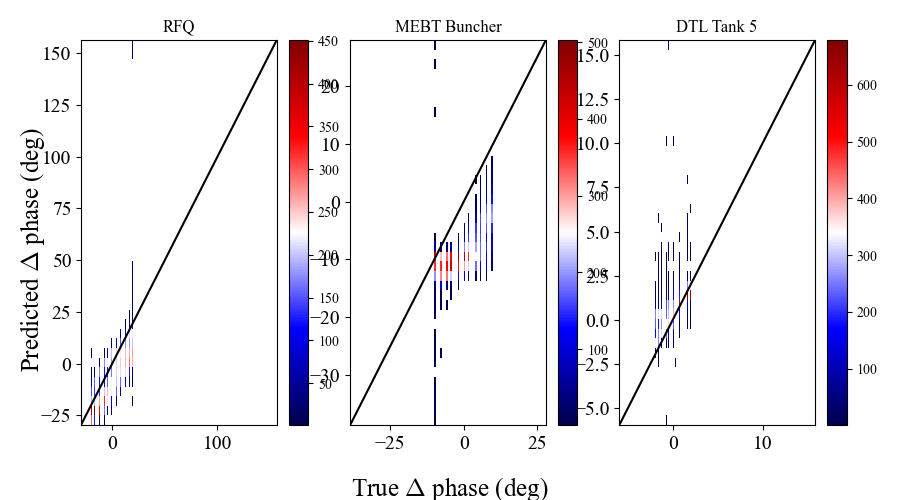

In [29]:
plot_2dhist(val_predictions,val_labels)

$\mu=-6.22$
$\sigma=7.65$
$\mu=-8.65$
$\sigma=4.64$
$\mu=0.56$
$\sigma=0.85$


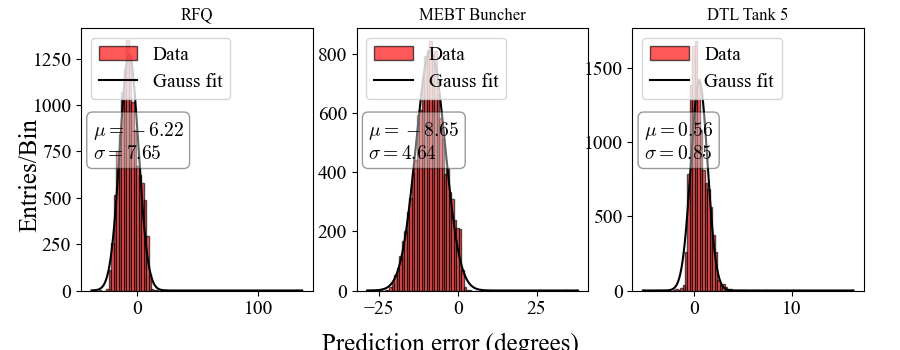

In [30]:
plot_1derror(val_predictions,val_labels)

In [171]:
plt.savefig("predictionErr_bad.pdf")

In [31]:
vdf = fetch_data(val2)
vdf = vdf - reference

val2_features,val2_labels = fetch_features_labels(vdf)
val2_predictions = dnn_model13.predict(val2_features)
print(val_labels.columns)

Index(['L:RFQPAH', 'L:RFBPAH', 'L:V5QSET'], dtype='object')


[-14.757547, 17.333508]
[-8.059906, 13.057036]
[-0.35896596, 2.4534407]
$\mu=1.81$
$\sigma=4.86$
$\mu=0.80$
$\sigma=3.67$
$\mu=0.98$
$\sigma=0.53$


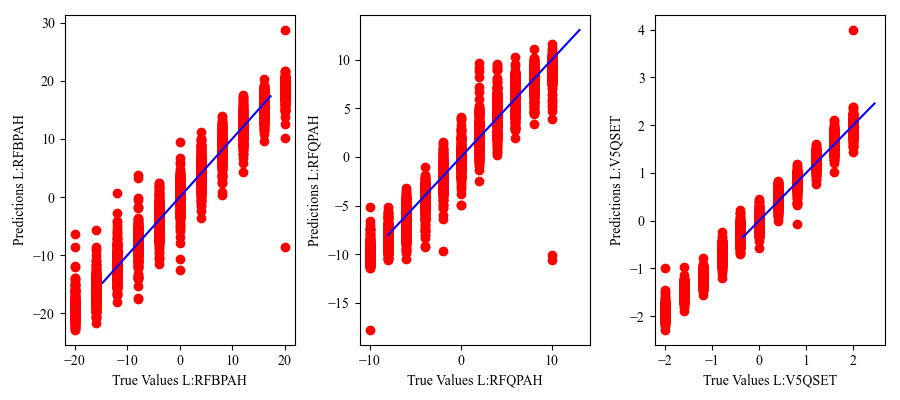

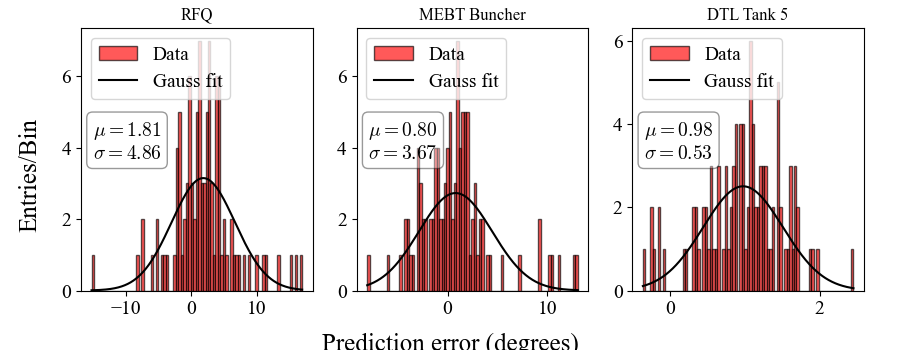

In [32]:
plot_2dscatter(val2_predictions,val2_labels)
plot_1derror(val2_predictions,val2_labels)

In [166]:
vdf = fetch_data(val3)
vdf = vdf - reference

val3_features,val3_labels = fetch_features_labels(vdf)
val3_predictions = dnn_model13.predict(val3_features)
print(val3_labels.columns)

Index(['L:RFBPAH', 'L:RFQPAH', 'L:V5QSET'], dtype='object')


$\mu=6.53$
$\sigma=2.90$
$\mu=2.21$
$\sigma=2.53$
$\mu=-0.13$
$\sigma=0.18$


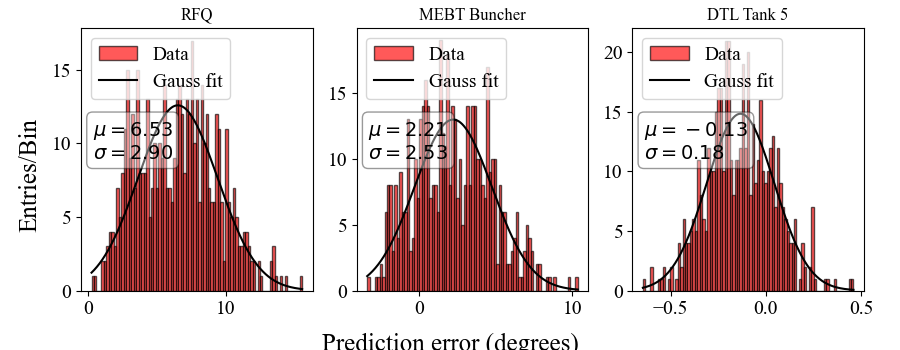

In [167]:
plot_1derror(val3_predictions,val3_labels)